In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
from zipfile import ZipFile

data_path = r'C:\Users\nishantjairath\Downloads\lung_colon_image_set.zip'

with ZipFile(data_path, 'r') as zipObj:
    zipObj.extractall(r'C:\Users\nishantjairath\Downloads')

In [2]:
# Data visualization

path = 'lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

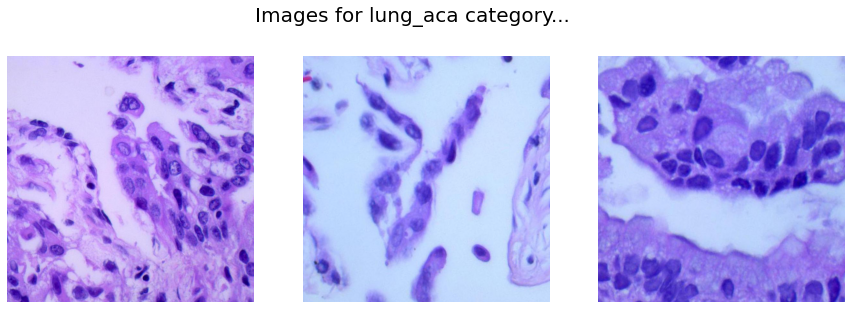

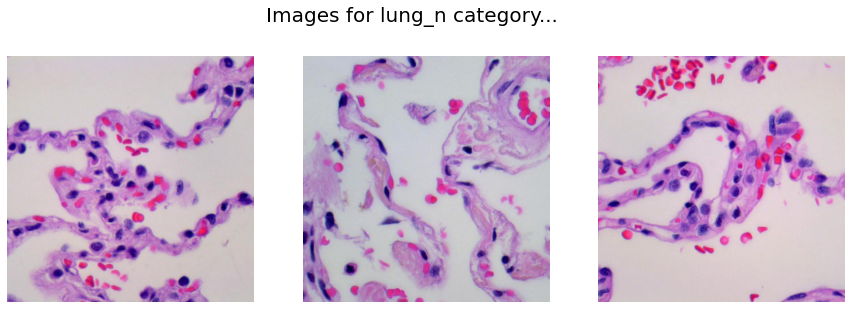

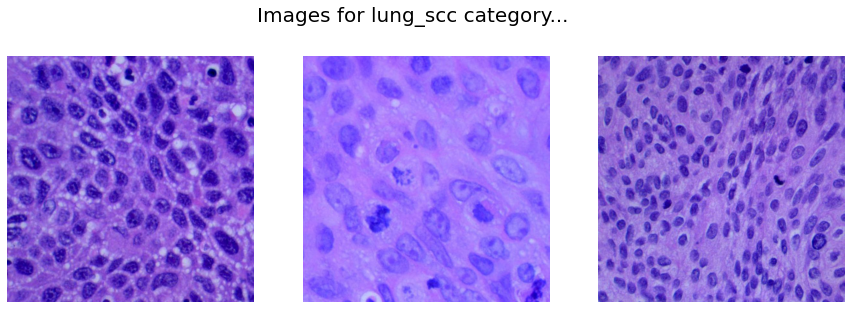

In [3]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category...', fontsize = 20)
    
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [4]:
# Convert images into NumPy arrays

IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [5]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    
    for image in images:
        img = cv2.imread(image)
        
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)
        #print(Y)
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [30]:
print(one_hot_encoded_Y)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [32]:
# Using One hot encoding output for predicting soft probabilities of image
# form each class with the highest probability for the class to which it belongs to

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)

print(Y_train.shape, Y_val.shape)

# train_test_split also helps in shuffling the data as it splits the data 
# randomly in the given ratio

(12000, 3) (3000, 3)


# Model Development

We will implement a "Sequential model" which will contain the following parts:

Three Convolutional Layers followed by MaxPooling Layers.
The Flatten layer to flatten the output of the convolutional layer.
Then we will have two fully connected layers followed by the output of the flattened layer.
We have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.
The final layer is the output layer which outputs soft probabilities for the three classes. 

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
input_shape = (IMG_SIZE, IMG_SIZE, 3),
weights = 'imagenet',
include_top = False)

In [33]:
len(pre_trained_model.layers)

311

'''
This is how deep this model is this also justifies why this model is highly effective in extracting useful features from images which helps us to build classifiers.

The parameters of a model we import are already trained on millions of images and for weeks so, we do not need to train them again.
'''

In [34]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [35]:
# 'Mixed7' is one of the layers in the inception network whose outputs we will use to build the classifier

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 768)


In [36]:
# defining layers of model

x = layers.Flatten()(last_output)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(0.3)(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation = 'softmax')(x)

model = keras.Model(pre_trained_model.input, output)

In [37]:
#from keras import optimizers, losses, activations, models

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [38]:
# Callback

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('val_accuracy') > 0.9:
            print('\n Validation accuracy has reached upto 90%')
            self.model.stop_training = True
            
es = EarlyStopping(patience = 3,
                  monitor = 'val_accuracy',
                  restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                      patience = 2,
                      factor = 0.5,
                      verbose = 1)

In [39]:
print(Y_train.shape, Y_val.shape)

(12000, 3) (3000, 3)


In [40]:
# training the model

history = model.fit(X_train, Y_train,
                   validation_data = (X_val, Y_val),
                   batch_size = BATCH_SIZE,
                   epochs = EPOCHS,
                   verbose = 1,
                   callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - 918s 5s/step - loss: 1.0986 - accuracy: 0.3344 - val_loss: 1.0986 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 910s 5s/step - loss: 1.0986 - accuracy: 0.3344 - val_loss: 1.0986 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.3344 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 2315s 12s/step - loss: 1.0986 - accuracy: 0.3344 - val_loss: 1.0986 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 994s 5s/step - loss: 1.0986 - accuracy: 0.3344 - val_loss: 1.0986 - val_accuracy: 0.3290 - lr: 5.0000e-04


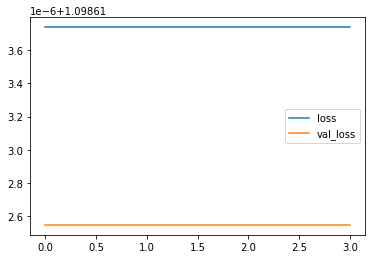

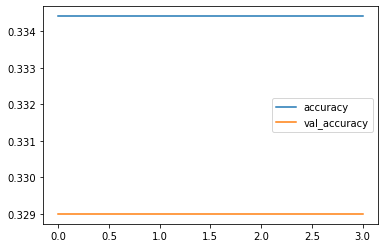

In [41]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [22]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 129s 1s/step


In [23]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[ 987,    0,    0],
       [ 977,    0,    0],
       [1036,    0,    0]], dtype=int64)

In [24]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.33      1.00      0.50       987
      lung_n       0.00      0.00      0.00       977
    lung_scc       0.00      0.00      0.00      1036

    accuracy                           0.33      3000
   macro avg       0.11      0.33      0.17      3000
weighted avg       0.11      0.33      0.16      3000



C:\Users\nishantjairath\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishantjairath\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nishantjairath\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
